In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

os.chdir('../../')
sys.path.append('./')
from utils.locality_utilities import *
from utils.utils import *

rc={'font.size': 19, 'axes.labelsize': 20, 'legend.fontsize': 18, 
    'axes.titlesize': 21, 'xtick.labelsize': 17, 'ytick.labelsize': 17}
sns.set(rc=rc)

sns.set_style("whitegrid")
pal = sns.color_palette('deep', 10)
pal = pal.as_hex()


/work/jdy/davin/WasG/utils/locality_utilities.py:15: UserWarning: torchattacks not imported
  warnings.warn('torchattacks not imported')


In [ ]:
abs = True # take absolute value

exp_save_path = './Files/Results/saved_explanations_1.24_1k'
dataset = 'divorce'
seed = 0
print(f"Loading data...")
filename = os.path.join(exp_save_path, '%s_samples_%s.pkl' % (dataset, str(seed)))
sample_dict = load_dict(filename)
test_images, test_labels = sample_dict['test_images'], sample_dict['test_labels']
print('done!')

explanation_methods = [
    # 'sage',
    # 'deepshap',
    # 'inputxgrad',
    # 'deeplift',
    # 'smoothgbp',
    'smoothgrad',
    'smoothig',
    # 'randGlobal',
    ]
std_list = [10, 1, 1e-1, 0]
std_list = list(map(float, std_list)) # convert to float
l2_max = 0

print('loading saved explanations...')
expref = {}
for explainer in explanation_methods:
    for std in std_list:
        if explainer[:6] != 'smooth' and std != 0: # skip std parameter if not a smoothed explanation
            continue
        filename = os.path.join(exp_save_path, '%s_%s_%s_%s.pkl' % (dataset, explainer, str(std), str(seed)))
        try:
            output = load_dict(filename)
            expref[explainer + '_%s' % str(std)] = output['explanations']
            if abs: expref[explainer + '_%s' % str(std)] = np.abs(expref[explainer + '_%s' % str(std)])
            l2_max = max(l2_max, np.linalg.norm(expref[explainer + '_%s' % str(std)], axis = 1).max())
                
        except:
            warnings.warn('File not found: %s' % filename)
            continue

expref['labels'] = test_labels
expref['images'] = test_images
print('done!')

print('l2_max: %s' % str(l2_max))

Loading data...
done!
loading saved explanations...
done!
l2_max: 0.8324218490914046


In [ ]:
test_params = {}
test_params['nUnif'] = 10000
test_params['seed'] = 0
test_params['l2_bound'] = l2_max
test_params['centering'] = 'mean'
df_results = pd.DataFrame()



###################################
test_params['testname'] = 'Euclidean_Reals_Slice'
test_params['metric'] = 'euclidean'
test_params['abs'] = False
test_params['exp_norm'] = 'sphere_l2_bound'
test_params['solver'] = 'pot_slice_symmetric'
test_params['l2_bound'] = l2_max

for std in std_list:
    test_params['std'] = std
    test_params['WG'] = wasserstein_globalness(expref['smoothgrad_%s' % std], n_unif=test_params['nUnif'], seed =test_params['seed'], l2_bound = test_params['l2_bound'], log = False, metric =test_params['metric'], abs =test_params['abs'], exp_norm = test_params['exp_norm'], solver =test_params['solver'], centering = test_params['centering'])
    tmp = pd.DataFrame(test_params, index=[0])
    df_results = pd.concat([df_results, tmp], axis=0)


###################################
test_params['testname'] = 'Euclidean_Positive_Slice'
test_params['metric'] = 'euclidean'
test_params['abs'] = True
test_params['exp_norm'] = 'sphere_l2_bound'
test_params['solver'] = 'pot_slice_symmetric'
test_params['l2_bound'] = 1

for std in std_list:
    test_params['std'] = std
    test_params['WG'] = wasserstein_globalness(expref['smoothgrad_%s' % std], n_unif=test_params['nUnif'], seed =test_params['seed'], l2_bound = test_params['l2_bound'], log = False, metric =test_params['metric'], abs =test_params['abs'], exp_norm = test_params['exp_norm'], solver =test_params['solver'], centering = test_params['centering'])
    tmp = pd.DataFrame(test_params, index=[0])
    df_results = pd.concat([df_results, tmp], axis=0)

###################################
test_params['testname'] = 'Euclidean_01_Slice'
test_params['metric'] = 'euclidean'
test_params['abs'] = True
test_params['exp_norm'] = 'sphere_l2_bound'
test_params['solver'] = 'pot_slice_symmetric'
test_params['l2_bound'] = 2

for std in std_list:
    test_params['std'] = std
    test_params['WG'] = wasserstein_globalness(expref['smoothgrad_%s' % std], n_unif=test_params['nUnif'], seed =test_params['seed'], l2_bound = test_params['l2_bound'], log = False, metric =test_params['metric'], abs =test_params['abs'], exp_norm = test_params['exp_norm'], solver =test_params['solver'], centering = test_params['centering'])
    tmp = pd.DataFrame(test_params, index=[0])
    df_results = pd.concat([df_results, tmp], axis=0)

###################################
test_params['testname'] = 'ranking'
test_params['metric'] = 'kendalltau'
test_params['abs'] = False # this doesn't do anything
test_params['exp_norm'] = 'NA' # this doesn't do anything
test_params['solver'] = 'pot' # this doesn't do anything
test_params['l2_bound'] = 1 # this doesn't do anything
test_params['nUnif'] = 100

for std in tqdm(std_list):
    test_params['std'] = std
    test_params['WG'] = wasserstein_globalness(expref['smoothgrad_%s' % std][:100,:], n_unif=test_params['nUnif'], seed =test_params['seed'], l2_bound = test_params['l2_bound'], log = False, metric =test_params['metric'], abs =test_params['abs'], exp_norm = test_params['exp_norm'], solver =test_params['solver'], centering = test_params['centering'])
    tmp = pd.DataFrame(test_params, index=[0])
    df_results = pd.concat([df_results, tmp], axis=0)

100%|██████████| 4/4 [00:30<00:00,  7.67s/it]


In [5]:
df_results

,nUnif,seed,l2_bound,centering,testname,metric,abs,exp_norm,solver,std,WG
0,10000,0,0.832422,mean,Euclidean_Reals_Slice,euclidean,False,sphere_l2_bound,pot_slice_symmetric,10.0,0.949791
0,10000,0,0.832422,mean,Euclidean_Reals_Slice,euclidean,False,sphere_l2_bound,pot_slice_symmetric,1.0,0.818938
0,10000,0,0.832422,mean,Euclidean_Reals_Slice,euclidean,False,sphere_l2_bound,pot_slice_symmetric,0.1,0.781795
0,10000,0,0.832422,mean,Euclidean_Reals_Slice,euclidean,False,sphere_l2_bound,pot_slice_symmetric,0.0,0.774225
0,10000,0,1.000000,mean,Euclidean_Positive_Slice,euclidean,True,sphere_l2_bound,pot_slice_symmetric,10.0,0.958087
0,10000,0,1.000000,mean,Euclidean_Positive_Slice,euclidean,True,sphere_l2_bound,pot_slice_symmetric,1.0,0.846299
0,10000,0,1.000000,mean,Euclidean_Positive_Slice,euclidean,True,sphere_l2_bound,pot_slice_symmetric,0.1,0.815071
0,10000,0,1.000000,mean,Euclidean_Positive_Slice,euclidean,True,sphere_l2_bound,pot_slice_symmetric,0.0,0.808840
0,10000,0,2.000000,mean,Euclidean_01_Slice,euclidean,True,sphere_l2_bound,pot_slice_symmetric,10.0,0.978902
0,10000,0,2.000000,mean,Euclidean_01_Slice,euclidean,True,sphere_l2_bound,pot_slice_symmetric,1.0,0.919866


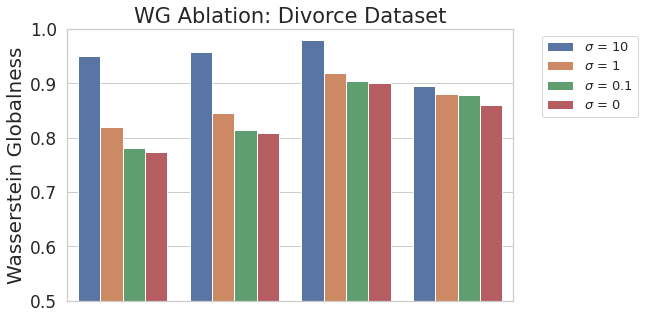

In [7]:
legend_mapping = {
    10: r'$\sigma$ = 10',
    1: r'$\sigma$ = 1',
    0.1: r'$\sigma$ = 0.1',
    0: r'$\sigma$ = 0',
}
df_results['std_clean'] = df_results['std'].map(legend_mapping)
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharey=True, sharex = True)
sns.barplot(data = df_results, hue = 'std_clean', x = 'testname', y = 'WG')

# # Annotate values above the bars
# for bar in ax.patches:
#     height = bar.get_height()
#     ax.text(
#         bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
#         height + .01,  # Y-coordinate (slightly above the bar)
#         f"{height:.2f}",  # Value annotation
#         ha='center',  # Horizontal alignment
#         va='bottom',  # Vertical alignment
#         fontsize = 12
#     )
ax.set_xticklabels([])
plt.ylim((0.5, 1))
plt.ylabel('Wasserstein Globalness')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',ncol=1, fancybox=True, shadow=False, fontsize = 13)
plt.title('WG Ablation: Divorce Dataset')
plt.savefig("./Figures/ablation_%s.pdf" % dataset,bbox_inches='tight', transparent=True)
plt.show()